<center>
    <h1>Fake News Classifier</h1>
<br>
<br>
I decided to re-do my original fake news classifier so I could condense it and and test out some other methods and make it look more cleaner. I plan to eventually re-do all my previous assignments now that my Python skills are constantly improving.
</center>

In [27]:
from __future__ import division
import numpy as np
from numpy.random import seed
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import interactive
import seaborn as sns
from IPython.display import display
import itertools
import sklearn_crfsuite
import eli5
import warnings
warnings.filterwarnings("ignore")

Import the two data sets (train and test) and name them 'train' and 'test'

In [28]:
train = pd.read_csv('fake_or_real_news_training.csv', index_col=0)
test = pd.read_csv('fake_or_real_news_test.csv', index_col=0)

Print the first 10 observations of the train set and their dimensions to take a look at the data

In [29]:
print("Train Shape:", train.shape, "\n Test Shape:", test.shape)
train.head(10)

Train Shape: (3999, 5) 
 Test Shape: (2321, 2)


,title,text,label,X1,X2
ID,,,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN
6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE,NaN,NaN
7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE,NaN,NaN
95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL,NaN,NaN
4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL,NaN,NaN


Take a look at the 'text' variable: we can see it's the beginning of the article itself 

In [30]:
train['text'][:10] 

ID
8476     Daniel Greenfield, a Shillman Journalism Fello...
10294    Google Pinterest Digg Linkedin Reddit Stumbleu...
3608     U.S. Secretary of State John F. Kerry said Mon...
10142    — Kaydee King (@KaydeeKing) November 9, 2016 T...
875      It's primary day in New York and front-runners...
6903       \nI’m not an immigrant, but my grandparents ...
7341     Share This Baylee Luciani (left), Screenshot o...
95       A Czech stockbroker who saved more than 650 Je...
4869     Hillary Clinton and Donald Trump made some ina...
2909     Iranian negotiators reportedly have made a las...
Name: text, dtype: object

Also, the data does not seem to be in ordered in any way so we can avoid shuffling the data to avoid any bias. There seems to be some text leakage into the X1 columns so we will fix that first.

In [31]:
bad_data = train.loc[train['X1'].notnull()]
print(bad_data.shape)
bad_data.head(33)

(33, 5)


,title,text,label,X1,X2
ID,,,,,
599,Election Day: No Legal Pot In Ohio,Democrats Lose In The South,Election Day: No Legal Pot In Ohio; Democrats ...,REAL,NaN
10194,Who rode it best? Jesse Jackson mounts up to f...,Leonardo DiCaprio to the rescue?,Who rode it best? Jesse Jackson mounts up to f...,FAKE,NaN
356,Black Hawk crashes off Florida,human remains found,(CNN) Thick fog forced authorities to suspend ...,REAL,NaN
2786,Afghanistan: 19 die in air attacks on hospital,U.S. investigating,(CNN) Aerial bombardments blew apart a Doctors...,REAL,NaN
3622,Al Qaeda rep says group directed Paris magazin...,US issues travel warning,A member of Al Qaeda's branch in Yemen said Fr...,REAL,NaN
7375,Shallow 5.4 magnitude earthquake rattles centr...,shakes buildings in Rome,00 UTC © USGS Map of the earthquake's epicent...,FAKE,NaN
9097,ICE Agent Commits Suicide in NYC,Leaves Note Revealing Gov’t Plans to Round-up...,Email Print After writing a lengthy suicide no...,FAKE,NaN
9203,Political Correctness for Yuengling Brewery,What About Our Opioid Epidemic?,We Are Change \n\nIn today’s political climate...,FAKE,NaN
1602,Poll gives Biden edge over Clinton against GOP...,VP meets with Trumka,A new national poll shows Vice President Biden...,REAL,NaN


In [32]:
bad_data.text = bad_data.text + " " + bad_data.label
bad_data.loc[9,'text'] = bad_data.loc[9,'text'] + " " + bad_data.loc[9,'X1']
bad_data.loc[6268,'text'] = bad_data.loc[6268,'text'] + " " + bad_data.loc[6268, 'X1']
bad_data.label = bad_data.iloc[:,3]
bad_data.loc[9,'label'] = 'REAL'
bad_data.loc[6268,'label'] = 'FAKE'
bad_data.drop(['X1', 'X2'], axis=1, inplace=True)
bad_data.columns = ['title', 'text', 'label']
bad_data.head(33)

,title,text,label
ID,,,
599,Election Day: No Legal Pot In Ohio,Democrats Lose In The South Election Day: No ...,REAL
10194,Who rode it best? Jesse Jackson mounts up to f...,Leonardo DiCaprio to the rescue? Who rode it ...,FAKE
356,Black Hawk crashes off Florida,human remains found (CNN) Thick fog forced au...,REAL
2786,Afghanistan: 19 die in air attacks on hospital,U.S. investigating (CNN) Aerial bombardments ...,REAL
3622,Al Qaeda rep says group directed Paris magazin...,US issues travel warning A member of Al Qaeda...,REAL
7375,Shallow 5.4 magnitude earthquake rattles centr...,shakes buildings in Rome 00 UTC © USGS Map o...,FAKE
9097,ICE Agent Commits Suicide in NYC,Leaves Note Revealing Gov’t Plans to Round-up...,FAKE
9203,Political Correctness for Yuengling Brewery,What About Our Opioid Epidemic? We Are Change...,FAKE
1602,Poll gives Biden edge over Clinton against GOP...,VP meets with Trumka A new national poll show...,REAL


In [33]:
train = train.drop(['X1', 'X2'], axis=1) # drop X1 and X2 so we can replace
train.loc[bad_data.index] = bad_data # replace

label
FAKE    1991
REAL    2008
Name: label, dtype: int64


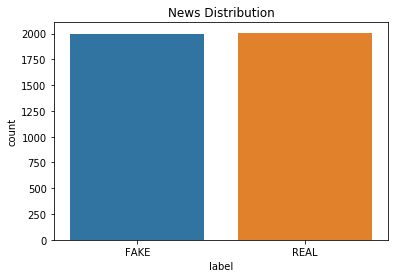

In [34]:
print(train.groupby('label')['label'].count())
sns.countplot('label', data=train)
plt.title('News Distribution')
plt.show()

It looks to be equally distributed between real and fake news.

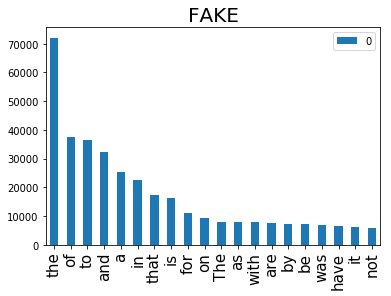

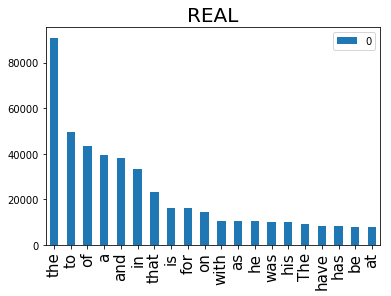

In [35]:
from nltk.tokenize import WhitespaceTokenizer


def news_word_analysis(dataset=train, col='text'):
    '''function to plot top words for each news label of respected data frame'''
    df = pd.DataFrame({col: dataset[col], "label": dataset.label})
    grouped = df.groupby(["label"]).apply(lambda x: x[col].sum())
    grouped_df = pd.DataFrame({"label": grouped.index, col: grouped.values})

    wpTokenizer = WhitespaceTokenizer()

    for index, text in enumerate(grouped_df[col]):
        pd.DataFrame(wpTokenizer.tokenize(text)).apply(pd.value_counts).head(20).plot(kind="bar")
        plt.title(grouped_df.label[index], fontsize=20)
        plt.xticks(fontsize=15)
        interactive(True)
        plt.show()
        
        
news_word_analysis()

We can see that the top words for each news label are stop words. We will have to apply some cleaning and transformations.

Next, we need to merge the title and text column.

In [36]:
label = train['label']
train.drop(['label'], axis=1, inplace=True)

train = train.apply(lambda x: " ".join(x), axis=1)
test = test.apply(lambda x: " ".join(x), axis=1)

# save back to DF
train = pd.DataFrame(train)
train.columns = ['text'] # re-insert column name
test = pd.DataFrame(test)
test.columns = ['text']

train['label'] = label
train.head()

,text,label
ID,,
8476,You Can Smell Hillary’s Fear Daniel Greenfield...,FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE
3608,Kerry to go to Paris in gesture of sympathy U....,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,FAKE
875,The Battle of New York: Why This Primary Matte...,REAL


In [37]:
test.head()

,text
ID,
10498,September New Homes Sales Rise——-Back To 1992 ...
2439,Why The Obamacare Doomsday Cult Can't Admit It...
864,"Sanders, Cruz resist pressure after NY losses,..."
4128,Surviving escaped prisoner likely fatigued and...
662,Clinton and Sanders neck and neck in Californi...


We can check the Lexical Diversity for each document which is stored in an array, showing the percentage of unique words over the total words in each data set

In [38]:
def lexical_diversity(df, row):
    '''function to find the lexical diversity on a given row'''
    return len(set(df.iloc[0, row])) / len(df.iloc[0, row])

# view the first row
print("Train Lexical Diversity: %1.4f" %lexical_diversity(train, 0),
      "\nTest Set Lexical Diversity: %1.4f" %lexical_diversity(test, 0))

Train Lexical Diversity: 0.0078 
Test Set Lexical Diversity: 0.0859


Let's create some new columns to show some information about the articles. We will create columns for each article: character counts, word count, average word, stop word count.

In [39]:
from nltk.corpus import stopwords


def article_stats(df):
    '''function to gather the original: character counts, word counts, average words per tweet, stop word counts,
    hashtag counts, and tag counts and saves them to the data frame, as well as print the numbers for each
    sentiment'''
    # character counts
    df['char_count'] = df['text'].str.len()

    # word counts
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))

    # average words
    def avg_word(sentence):
        '''function to get the average word length for total length'''
        words = sentence.split()
        return (sum(len(word) for word in words) / len(words))
    df['avg_word'] = df['text'].apply(lambda x: avg_word(x))

    # stop words
    sw = stopwords.words('english')
    df['stopwords'] = df['text'].apply(lambda word: len([word for word in word.split() if word in sw]))

    
article_stats(train)

char_avg_sent = train.groupby('label').apply(lambda x: x['char_count'].mean())
print("char_avg_sent : {}".format(char_avg_sent))

word_avg_sent = train.groupby('label').apply(lambda x: x['word_count'].mean())
print("word_avg_sent : {}".format(word_avg_sent))

avg_word_avg_sent = train.groupby('label').apply(lambda x: x['avg_word'].mean())
print("avg_word_avg_sent : {}".format(avg_word_avg_sent))

sw_avg_sent = train.groupby('label').apply(lambda x: x['stopwords'].mean())
print("sw_avg_sent : {}".format(sw_avg_sent))

char_avg_sent : label
FAKE    4185.105475
REAL    5357.726594
dtype: float64
word_avg_sent : label
FAKE    688.593672
REAL    862.599602
dtype: float64
avg_word_avg_sent : label
FAKE    5.125589
REAL    5.080449
dtype: float64
sw_avg_sent : label
FAKE    259.354093
REAL    335.291335
dtype: float64


In [40]:
article_stats(test)

train.head()

,text,label,char_count,word_count,avg_word,stopwords
ID,,,,,,
8476,You Can Smell Hillary’s Fear Daniel Greenfield...,FAKE,7547,1303,4.776326,531
10294,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE,2732,460,4.923913,174
3608,Kerry to go to Paris in gesture of sympathy U....,REAL,2587,432,4.863636,176
10142,Bernie supporters on Twitter erupt in anger ag...,FAKE,2745,419,5.522673,132
875,The Battle of New York: Why This Primary Matte...,REAL,1889,316,4.766871,121


We can see that real news articles tend to be long, have a higher average word per sentence and have more stopwords.

<h3>Transforming the Data</h3>
<br>
First let us lowercase, clean up some urls and clean up the contractions.

In [41]:
import string
import re


def lower_case(text):
    '''function to lowercase''' 
    text = text.lower() # lowercase all
    return text

train['text'] = train['text'].apply(lower_case)
test['text'] = test['text'].apply(lower_case)

In [42]:
def remove_url(text):
    '''function to remove urls'''
    text = re.sub(r"(http|https|ftp)://[a-zA-Z0-9\./]+", "", text, flags=re.MULTILINE)
    return text

train['text'] = train['text'].apply(remove_url)
test['text'] = test['text'].apply(remove_url)

In [43]:
contractions_dic = {"isn't":"is not", "isnt":"is not", "aren't":"are not", "arent":"are not", "wasn't":"was not", 
                    "wasnt":"was not","weren't":"were not", "werent":"were not","haven't":"have not",
                    "havent":"have not","hasn't":"has not","hasnt":"has not","hadn't":"had not","hadnt":"had not",
                    "won't":"will not","wont":"will not","wouldn't":"would not","wouldnt":"would not", 
                    "don't":"do not","dont":"do not", "doesn't":"does not","doesnt":"does not","didn't":"did not",
                    "didnt":"did not","can't":"can not","cant":"can not", "couldn't":"could not",
                    "couldnt":"could not","shouldn't":"should not","shouldnt":"should not", "mightn't":"might not", 
                    "mightnt":"might not","mustn't":"must not","mustnt":"must not", "i'm":"i am","what's":"what is",
                    "we'll": "we will","i've":"i have","we're":"we are", "we've":"we have", "you've": "you have",
                    "they've":"they have","ain't":"did not","could've":"could have","daren't":"dare not",
                    "everyone's":"everyone is","finna":"fixing to","gimme":"give me","gonna":"going to",
                    "he's":"he is","he've":"he have","how'd":"how did","how'll":"how will","how're":"how are",
                    "how's":"how is","i'd":"i would","i'll":"i will","it'll":"it will","it's":"it has",
                    "let's":"let us","ma'am":"madam","may've":"may have","might've":"might have","needn't":"need not",
                    "o'clock":"of the clock","ol'":"old","oughtn't":"ought not","shan't":"shall not",
                    "she'd":"she would","she'll":"she will","she's":"she is","should've":"should have",
                    "somebody's":"somebody is","someone's":"someone is","that'll":"that will","that's":"that is",
                    "that'd":"that would","there'll":"there will","there's":"there is","they'd":"they would",
                    "they'll":"they will","they're":"they are","'tis":"it is","'twas":"it was","we'd":"we would",
                    "we'd":"we would have","we'll":"we will","we're":"we are","we've":"we have","what'd":"what did",
                    "when's":"when is","where's":"where is","who'd":"who would","who'll":"who will","who's":"who is",
                    "why'd":"why did","would've":"would have","y'all":"you all","you'd":"you would", 
                    "you'll":"you will","you're":"you are","you've":"you have","gotta":"got to","he'd":"he would",
                    "he'll":"he will","&":"and","im":"i am","ha":"has",'its':'it is',"’s":'', "'s":"", "jan":"january",
                    "feb":"february","mar":"march","apr":"april","jun":"june","jul":"july","aug":"august",
                    "sep":"september","sept":"september","oct":"october","nov":"november","dec":"december"}

contractions_pattern = re.compile(r'\b(' + '|'.join(contractions_dic.keys()) + r')\b')

def decontract(text):
    text = contractions_pattern.sub(lambda x: contractions_dic[x.group()], text)
    #text = text.strip(' ')
    return text

train['text'] = train['text'].apply(decontract)
test['text'] = test['text'].apply(decontract)

train.head()

,text,label,char_count,word_count,avg_word,stopwords
ID,,,,,,
8476,"you can smell hillary fear daniel greenfield, ...",FAKE,7547,1303,4.776326,531
10294,watch the exact moment paul ryan committed pol...,FAKE,2732,460,4.923913,174
3608,kerry to go to paris in gesture of sympathy u....,REAL,2587,432,4.863636,176
10142,bernie supporters on twitter erupt in anger ag...,FAKE,2745,419,5.522673,132
875,the battle of new york: why this primary matte...,REAL,1889,316,4.766871,121


In [44]:
def remove_punctuation(text):
    '''function to remove punctuation''' 
    text = re.sub("[^a-zA-Z]", " ", text)
    text = re.sub(' +', ' ', text) # clear extra white spaces
    return text

train['text'] = train['text'].apply(remove_punctuation)
test['text'] = test['text'].apply(remove_punctuation)

train.head()

,text,label,char_count,word_count,avg_word,stopwords
ID,,,,,,
8476,you can smell hillary fear daniel greenfield a...,FAKE,7547,1303,4.776326,531
10294,watch the exact moment paul ryan committed pol...,FAKE,2732,460,4.923913,174
3608,kerry to go to paris in gesture of sympathy u ...,REAL,2587,432,4.863636,176
10142,bernie supporters on twitter erupt in anger ag...,FAKE,2745,419,5.522673,132
875,the battle of new york why this primary matter...,REAL,1889,316,4.766871,121


Decided to use TextBlob to tokenize and lemmatize since it worked better than the NLTK packaged. Stemming didn't improve the score and takes away some word meanings.

In [45]:
from textblob import TextBlob, Word


def tokenize_text(text):
    '''function to tokenize text'''
    text = TextBlob(text).words
    return text

# tokenize and lemmatize
train['text'] = train['text'].apply(tokenize_text)
train['text'] = train['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x]))

test['text'] = test['text'].apply(tokenize_text)
test['text'] = test['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x]))

train.head()

,text,label,char_count,word_count,avg_word,stopwords
ID,,,,,,
8476,you can smell hillary fear daniel greenfield a...,FAKE,7547,1303,4.776326,531
10294,watch the exact moment paul ryan committed pol...,FAKE,2732,460,4.923913,174
3608,kerry to go to paris in gesture of sympathy u ...,REAL,2587,432,4.863636,176
10142,bernie supporter on twitter erupt in anger aga...,FAKE,2745,419,5.522673,132
875,the battle of new york why this primary matter...,REAL,1889,316,4.766871,121


<h3>Text Analysis</h3>

We can get the total counts of tokens.

In [46]:
from sklearn.feature_extraction.text import CountVectorizer


def get_counts(df):
    ''' function to get total counts'''
    vectorizer = CountVectorizer()
    counts = vectorizer.fit_transform(df.text) 
    return len(vectorizer.get_feature_names())

print("Train Tokens: {}, Test Tokens: {}".format(get_counts(train), get_counts(test)))

Train Tokens: 48049, Test Tokens: 37933


In [47]:
most_common = pd.Series(' '.join(train['text']).split()).value_counts()[:10]
most_common.index

Index(['the', 'a', 'to', 'of', 'and', 'in', 'that', 'is', 'for', 'it'], dtype='object')

The most popular tokens are stop words.

In [48]:
rarest = pd.Series(' '.join(train['text']).split()).value_counts()[-10:]
rarest.index

Index(['bisbee', 'jkennedy', 'scornfully', 'telelvisions', 'norse',
       'joshthewumba', 'aeronautics', 'alaweed', 'splenetic', 'johnna'],
      dtype='object')

We can use WordCloud to show the top words in a more visual sense.

In [49]:
from wordcloud import WordCloud

def create_wordcloud(label_class):
    articles = train[train['label'] == label_class]
    pos_string = []
    for article in articles.text:
        pos_string.append(article)
    pos_string = pd.Series(pos_string).str.cat(sep=' ')


    wordcloud_pos = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud_pos, interpolation="bilinear")
    plt.title("{} Text WordCloud".format(label_class), fontsize=30, fontweight="bold")
    plt.axis("off")
    plt.show()

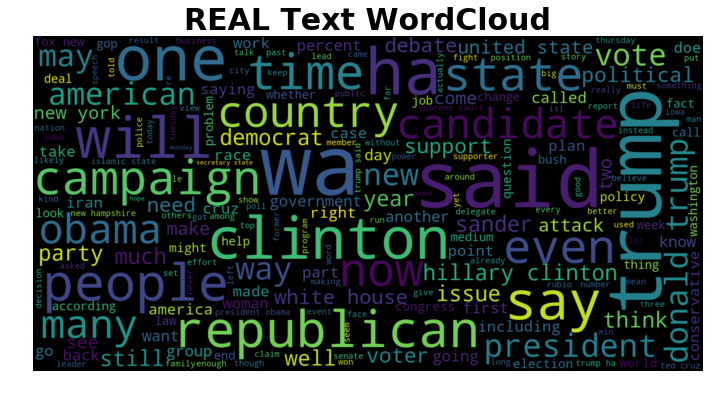

In [50]:
create_wordcloud('REAL')

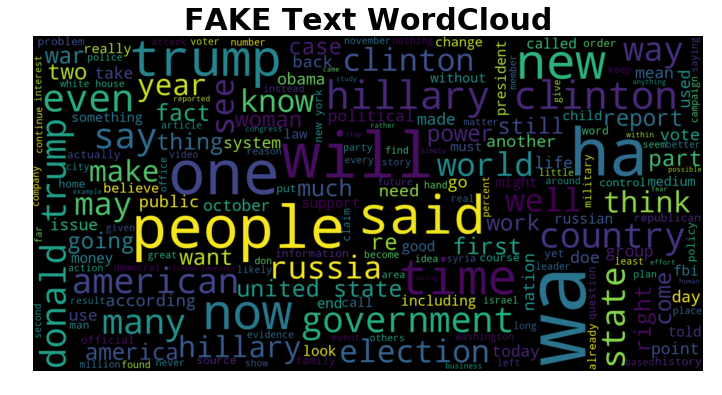

In [51]:
create_wordcloud('FAKE')

<h3>Transformation</h3>
<br>
Transfrom the target variable into binary for easy Machine Learn use (SVM doesn't take strings).

In [52]:
from sklearn import preprocessing


print(train.groupby(['label'])['text'].count())

le = preprocessing.LabelEncoder()
label = train['label'] # make sure we save it
target = le.fit_transform(train['label'])

train.drop('label', axis=1, inplace=True)

print(np.unique(target, return_counts=True))

label
FAKE    1991
REAL    2008
Name: text, dtype: int64
(array([0, 1]), array([1991, 2008]))


We will split the data into train and test so we can tune the parameters on the train set with cross-validation and then see evaluate on the test data.

In [83]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=69)

print(X_train.shape)
X_train.head()

(3199, 5)


,text,char_count,word_count,avg_word,stopwords
ID,,,,,
1953,jeb bush preview run promising adult conversat...,6699,1105,4.921099,432
2862,iraqi force civilian flee a isi gain control o...,8503,1329,5.213500,481
7590,puh leeze doj policy reminder to fbi is shamel...,926,140,5.611511,34
7798,transforming hope into reality for patient of ...,5091,851,4.983549,305
201,cameron set to press obama on tech encryption ...,3492,572,5.057292,214


<h3>TFIDF Vectorizer</h3>

Here we will use the TF-IDF Vectorizer. We will avoid using both Count and Hash Vectorizers since in the original assignment, we new that TF-IDF was superior in this context. So let us move straight to it. Also, we will use max features parameter since there are over 43,000 distinct words before applying bigrams and trigrams.

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer


# different ngrams combinations
unigrams = (1,1)
bigrams = (1,2)
trigrams = (1,3)
ngrams = (1,4)

tfidf = TfidfVectorizer(stop_words='english', ngram_range=trigrams, max_features=100000)  
tfidf_train = tfidf.fit_transform(X_train['text'])
tfidf_valid = tfidf.transform(X_test['text'])
tfidf_test = tfidf.transform(test['text'])

print("TFIDF Data Frame Shape : {}".format(tfidf_train.shape))
print("First 10 features: ", tfidf.get_feature_names()[:10])

TFIDF Data Frame Shape : (3199, 100000)
First 10 features:  ['aa', 'aa superluminal', 'aa superluminal sign', 'aab', 'aaeeb', 'aaeeb dhrcofficecom', 'aaj', 'aap', 'aaron', 'aaron sorkin']


In [85]:
import scipy as sp


cols_to_keep = ['char_count', 'word_count', 'avg_word', 'stopwords']
X_train = sp.sparse.hstack((tfidf_train, X_train[cols_to_keep]), format='csr')

X_test = sp.sparse.hstack((tfidf_valid, X_test[cols_to_keep]), format='csr')

Test = sp.sparse.hstack((tfidf_test, test[cols_to_keep]), format='csr')

We will evaluate our models by using a confusion matrix. I found a nice confusion matrix code from a Data Camp tutorial at https://www.datacamp.com/community/tutorials/scikit-learn-fake-news.

In [59]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    '''function to plot a confusion matrix'''
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

Here, we will use Naive Bayes model to test both the full df and solely the TFIDF Vectorizer.
<br>
<br>
<b>HStack</b>

In [86]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


nb = MultinomialNB()

nbh = nb.fit(X_train, y_train)
pred1h = nbh.predict(X_test)
score1h = metrics.accuracy_score(y_test, pred1h)
print("accuracy:   %0.3f" % score1h)

accuracy:   0.570


<b>TFIDF</b>

In [87]:
nb.fit(tfidf_train, y_train)
pred1 = nb.predict(tfidf_valid)
score1 = metrics.accuracy_score(y_test, pred1)
print("accuracy:   %0.3f" % score1)

accuracy:   0.845


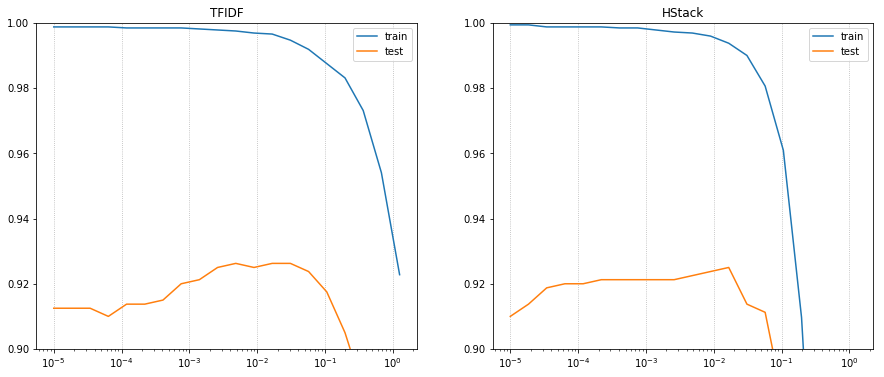

In [88]:
alphas = np.logspace(-5, .1, 20)

# tfidf
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
train_acc = []
test_acc = []

for alpha_ in alphas:

    nb = MultinomialNB(alpha=alpha_)
    nb.fit(tfidf_train, y_train)
    
    train_acc.append(nb.score(tfidf_train, y_train))
    test_acc.append(nb.score(tfidf_valid, y_test))
    

plt.semilogx(alphas, train_acc, alphas, test_acc)
plt.legend(("train", "test"))
plt.gca().xaxis.grid(linestyle='dotted')
plt.ylim((.9, 1))
plt.title("TFIDF")


# hstack
plt.subplot(1,2,2)
train_acch = []
test_acch = []

for alpha_ in alphas:
    # Create LogisticRegression object and fit
    nbh = MultinomialNB(alpha=alpha_)
    nbh.fit(X_train, y_train)
    
    # Evaluate error rates and append to lists
    train_acch.append(nbh.score(X_train, y_train))
    test_acch.append(nbh.score(X_test, y_test))
    

plt.semilogx(alphas, train_acch, alphas, test_acch)
plt.legend(("train", "test"))
plt.gca().xaxis.grid(linestyle='dotted')
plt.ylim((.9, 1))
plt.title("HStack")


plt.show()

Here we can see that the TFIDF fairs better than the HStack.

In [97]:
from sklearn.model_selection import cross_val_score, GridSearchCV


nb_params = {'alpha': np.linspace(.005, .05, 15)}

nb_cv = GridSearchCV(estimator=nb, param_grid=nb_params, cv= 10)
nb_cv.fit(tfidf_train, y_train)
print("Best Parameter: ", nb_cv.best_params_)

Best Parameter:  {'alpha': 0.043571428571428573}


Create some functions to fit the model and one to find an alternative method to finding the right alpha but without cross-validation (so we will just show the code and try it).

In [90]:
def fit_model(train, test, model, cm=False):
    '''function to fit and apply model with the option to show Confusion Matrix'''
    model.fit(train, y_train)
    pred = model.predict(test)
    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    if cm:
        cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])
        plot_confusion_matrix(cm, classes=['Fake', 'True'], title='Confusion Matrix')
    
# create function for alpha
def find_alpha(X_train, X_test, model, scaler, minimum=0, maximum=1, amount=10):
    '''function to find best alpha'''
    if scaler == 'log':
        alphas = np.logspace(minimum, maximum, amount)
    elif scaler == 'lin':
        alphas = np.linspace(minimum, maximum, amount)
    best_score = 0
    for alpha in alphas:
        alpha_model = model(alpha=alpha)
        alpha_model.fit(X_train, y_train)
        pred = alpha_model.predict(X_test)
        score = metrics.accuracy_score(y_test, pred)
        if score > best_score:
            clf = alpha_model
        print("Alpha: {:.5f} Score: {:.6f}".format(alpha, score))

In [91]:
find_alpha(tfidf_train, tfidf_valid, MultinomialNB, 'lin', .005, .05, 20)

Alpha: 0.00500 Score: 0.926250
Alpha: 0.00737 Score: 0.925000
Alpha: 0.00974 Score: 0.923750
Alpha: 0.01211 Score: 0.923750
Alpha: 0.01447 Score: 0.926250
Alpha: 0.01684 Score: 0.926250
Alpha: 0.01921 Score: 0.926250
Alpha: 0.02158 Score: 0.926250
Alpha: 0.02395 Score: 0.926250
Alpha: 0.02632 Score: 0.926250
Alpha: 0.02868 Score: 0.926250
Alpha: 0.03105 Score: 0.926250
Alpha: 0.03342 Score: 0.926250
Alpha: 0.03579 Score: 0.926250
Alpha: 0.03816 Score: 0.926250
Alpha: 0.04053 Score: 0.926250
Alpha: 0.04289 Score: 0.925000
Alpha: 0.04526 Score: 0.925000
Alpha: 0.04763 Score: 0.923750
Alpha: 0.05000 Score: 0.923750


The Find Alpha function is an alternative to using Grid Search but we will focus on the latter since it uses Cross-Validation.

accuracy:   0.914


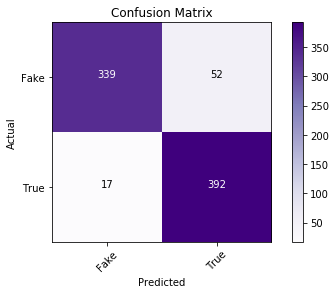

In [98]:
nb_model = MultinomialNB(alpha=0.043571428571428573)
fit_model(X_train, X_test, nb_model, cm=True)

This score are pretty good. Tuning alpha gave it an increase of 7%%. Let us now try Passive Aggressive Classifier. The find alpha function didn't really help so we won't use it anymore.

In [99]:
from sklearn.linear_model import PassiveAggressiveClassifier


pa = PassiveAggressiveClassifier(random_state=69)

pah = pa.fit(X_train, y_train)
pred2h = pah.predict(X_test)
score2h = metrics.accuracy_score(y_test, pred2h)
print("accuracy:   %0.3f" % score2h)

accuracy:   0.502


In [100]:
pa.fit(tfidf_train, y_train)
pred3 = pa.predict(tfidf_valid)
score3 = metrics.accuracy_score(y_test, pred3)
print("accuracy:   %0.3f" % score3)

accuracy:   0.936


For some reason, Passive Agressive works better with just text.

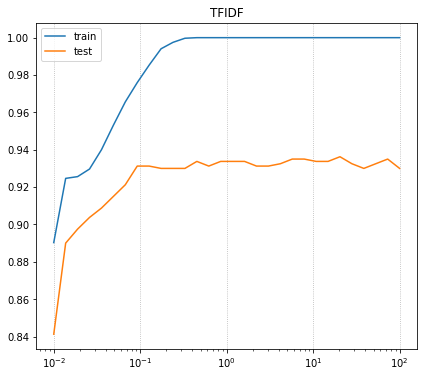

In [101]:
c = np.logspace(-2, 2, 30)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
train_acc = []
test_acc = []

for c_ in c:
    pa = PassiveAggressiveClassifier(C=c_)
    pa.fit(tfidf_train, y_train)
    
    train_acc.append(pa.score(tfidf_train, y_train))
    test_acc.append(pa.score(tfidf_valid, y_test))
    

plt.semilogx(c, train_acc, c, test_acc)
plt.legend(("train", "test"))
plt.gca().xaxis.grid(linestyle='dotted')
plt.title("TFIDF")

plt.show()

In [102]:
pa_params = {'C': np.linspace(1, 14, 20)}

pa_cv = GridSearchCV(estimator=pa, param_grid=pa_params, cv= 10)
pa_cv.fit(tfidf_train, y_train)
print("Best Parameter: ", pa_cv.best_params_)

Best Parameter:  {'C': 5.7894736842105265}


In [103]:
def find_C(X_train, X_test, model, scaler, minimum=0, maximum=1, total=10):
    '''function to find best C'''
    if scaler == 'log':
        C = np.logspace(minimum, maximum, total)
    elif scaler == 'lin':
        C = np.linspace(minimum, maximum, total)
    best_C_score = 0
    for c in C:
        C_model = model(C=c)
        C_model.fit(X_train, y_train)
        pred = C_model.predict(X_test)
        score = metrics.accuracy_score(y_test, pred)
        if score > best_C_score:
            clf = C_model
        print("C: {:.5f} Score: {:.5f}".format(c, score))

Same as the Find Alpha function, another alternative to using Grid Search but we will focus on the latter since it uses Cross-Validation.

In [104]:
find_C(tfidf_train, tfidf_valid, PassiveAggressiveClassifier, 'lin', 1, 14, 20)

C: 1.00000 Score: 0.93375
C: 1.68421 Score: 0.93750
C: 2.36842 Score: 0.93250
C: 3.05263 Score: 0.93375
C: 3.73684 Score: 0.93500
C: 4.42105 Score: 0.93250
C: 5.10526 Score: 0.93250
C: 5.78947 Score: 0.93500
C: 6.47368 Score: 0.93125
C: 7.15789 Score: 0.93000
C: 7.84211 Score: 0.93375
C: 8.52632 Score: 0.92500
C: 9.21053 Score: 0.93000
C: 9.89474 Score: 0.93375
C: 10.57895 Score: 0.93000
C: 11.26316 Score: 0.93125
C: 11.94737 Score: 0.93625
C: 12.63158 Score: 0.92500
C: 13.31579 Score: 0.92875
C: 14.00000 Score: 0.93625


accuracy:   0.931


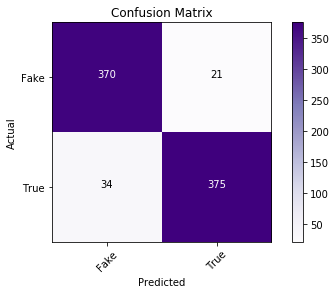

In [105]:
pa_model = PassiveAggressiveClassifier(C=5.7894736842105265)

fit_model(tfidf_train, tfidf_valid, pa_model, cm=True)

In [106]:
from nltk.classify import SklearnClassifier
from sklearn.svm import LinearSVC


svc = LinearSVC()

svc.fit(tfidf_train, y_train)
pred4 = svc.predict(tfidf_valid)
score4 = metrics.accuracy_score(y_test, pred4)
print("accuracy:   %0.3f" % score4)

accuracy:   0.931


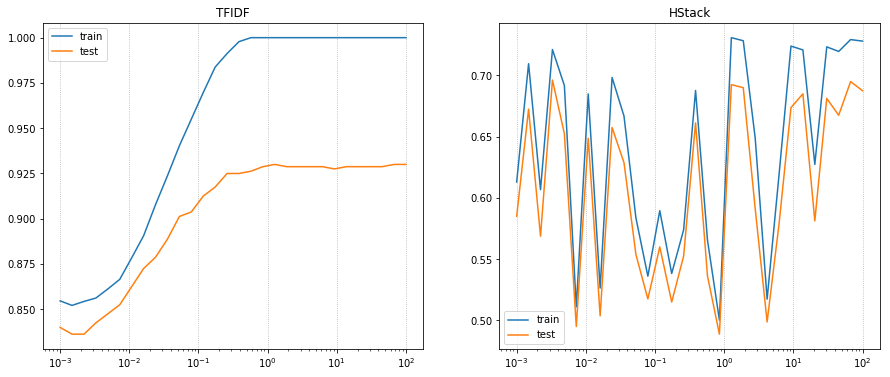

In [107]:
c = np.logspace(-3, 2, 30)

# tfidf
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
train_acc = []
test_acc = []

for c_ in c:
    svc = LinearSVC(C=c_)
    svc.fit(tfidf_train, y_train)
    
    train_acc.append(svc.score(tfidf_train, y_train))
    test_acc.append(svc.score(tfidf_valid, y_test))
    

plt.semilogx(c, train_acc, c, test_acc)
plt.legend(("train", "test"))
plt.gca().xaxis.grid(linestyle='dotted')
plt.title("TFIDF")


# hstack
plt.subplot(1,2,2)
train_acch = []
test_acch = []

for c_ in c:
    svch = LinearSVC(C=c_)
    svch.fit(X_train, y_train)
    
    train_acch.append(svch.score(X_train, y_train))
    test_acch.append(svch.score(X_test, y_test))
    

plt.semilogx(c, train_acch, c, test_acch)
plt.legend(("train", "test"))
plt.gca().xaxis.grid(linestyle='dotted')
plt.title("HStack")


plt.show()

TFIDF shows much better results.

In [108]:
svc_params = {'C': np.linspace(1, 5, 20)}

svc_cv = GridSearchCV(estimator=svc, param_grid=svc_params, cv= 10)
svc_cv.fit(tfidf_train, y_train)
print("The best parameters are %s with a score of %0.4f" % (svc_cv.best_params_, svc_cv.best_score_))

The best parameters are {'C': 4.3684210526315788} with a score of 0.9322


In [109]:
svc_model = LinearSVC(C=4.3684210526315788).fit(tfidf_train, y_train)
pred4 = svc_model.predict(tfidf_valid)
score4 = metrics.accuracy_score(y_test, pred4)
print("accuracy:   %0.3f" % score4)

accuracy:   0.929


So I tried multiple other by using all three different vectorizers and applying them to NB, Passive Aggressive and finally SVM. I will use a VotingClassifier to see if I can use the results from all the models.

Accuracy: 0.92529 (+/- 0.02) [Naive Bayes]
Accuracy: 0.93279 (+/- 0.01) [Passive Aggressive]
Accuracy: 0.92935 (+/- 0.01) [SVM]
Accuracy: 0.93248 (+/- 0.01) [Ensemble]


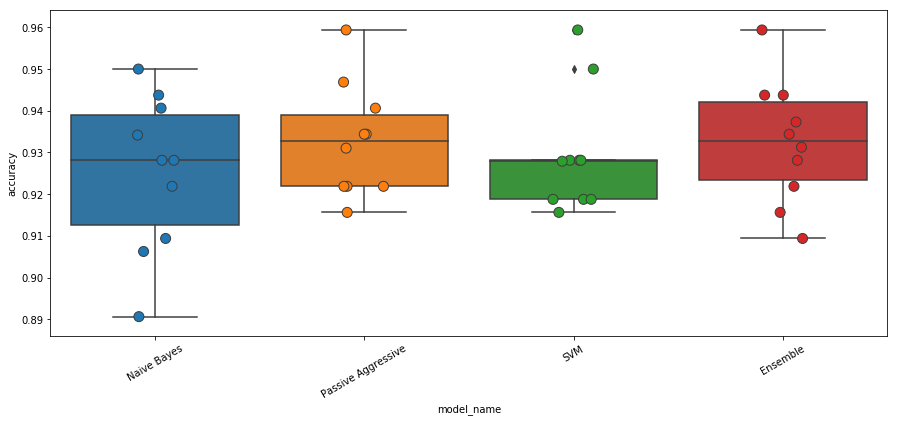

In [110]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
import seaborn as sns


def VC_Classifier_Plot(X, y, splits=10):
    '''function to create Voting Classifier'''
    kfold = StratifiedKFold(n_splits=splits, random_state=69, shuffle=True)
    VC = VotingClassifier(estimators=[('nb', nb_model), ('pa', pa_model), ('svm', svc_model)], voting='hard')

    VC_df = pd.DataFrame(index=range(3 * 3))

    preds = []
    for clf, lab in zip([nb_model, pa_model, svc_model, VC], ['Naive Bayes', 'Passive Aggressive', 'SVM', 'Ensemble']):
        model_name = lab
        scores = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy') 
        print("Accuracy: %0.5f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), lab))
        for fold, accuracy in enumerate(scores):
            preds.append((lab, fold, accuracy))

    VC_df = pd.DataFrame(preds, columns=['model_name', 'fold', 'accuracy'])

    plt.figure(figsize=(15,6))
    sns.boxplot(x='model_name', y='accuracy', data=VC_df)
    sns.stripplot(x='model_name', y='accuracy', data=VC_df, size=10, jitter=True, edgecolor="gray", linewidth=1)
    plt.xticks(rotation=30)
    plt.show()
    
VC_Classifier_Plot(tfidf_train, y_train)

In [111]:
VC_model = VotingClassifier(estimators=[('nb', nb_model), ('pa', pa_model), ('svm', svc_model)], voting='hard') 
VC_model.fit(tfidf_train, y_train)
pred5 = VC_model.predict(tfidf_valid)
score5 =  metrics.accuracy_score(y_test, pred5)
print("accuracy:   %0.3f" % score5)

accuracy:   0.931


We have our model! The Ensemble model cross-validated with the train and validation set and then predicted on our hold out set gives us a score of 93.1%! It was a small percentage less than the Passive Aggressive but we will just choose the VC as our final. We can also see that we are not overfitting since our cross-validated training data set predicted with almost the same accuracy on the validation set. Now to use the classifier in practice, we will now train the model on the full train data set.
<br>
<br>
<b>Most Real Tokens</b>

In [112]:
features = tfidf.get_feature_names()
sorted(zip(pa_model.coef_[0], features), reverse=True)[:20]

[(4.9812802603500987, 'said'),
 (2.4031055596891431, 'say'),
 (2.3067571824508013, 'conservative'),
 (2.2828284692415113, 'cruz'),
 (2.0087676772447387, 'attack'),
 (1.9777663775236929, 'republican'),
 (1.8565723389093738, 'tuesday'),
 (1.847765348441909, 'campaign'),
 (1.7415057419121471, 'candidate'),
 (1.6998263823170072, 'monday'),
 (1.697279658574643, 'netanyahu'),
 (1.6898566778946773, 'gop'),
 (1.6177397618568967, 'state'),
 (1.6136081072350246, 'sen'),
 (1.6026395929396633, 'fox news'),
 (1.5846744490507731, 'debate'),
 (1.5597009819885135, 'ha'),
 (1.483041013426152, 'sander'),
 (1.4809356897650894, 'convention'),
 (1.4593008011533848, 'sunday')]

<b>Most Fake Tokens</b>

In [113]:
sorted(zip(pa_model.coef_[0], features))[:20]

[(-5.0781824166413365, 'october'),
 (-2.8687371840253375, 'hillary'),
 (-2.5511034414704716, 'november'),
 (-2.5331163159495818, 'article'),
 (-2.3701330623635966, 'mosul'),
 (-2.1899688624503879, 'source'),
 (-2.0252409492159886, 'share'),
 (-1.9582910618505747, 'war'),
 (-1.7856239989224871, 'fbi'),
 (-1.7170727694890402, 'wikileaks'),
 (-1.5162489948283908, 'advertisement'),
 (-1.4826572823086737, 'podesta'),
 (-1.4736354179768614, 'breaking'),
 (-1.4391209669519804, 'election'),
 (-1.4190261446392292, 'com'),
 (-1.3716189379326811, 'video'),
 (-1.3704890214492353, 'donald trump'),
 (-1.3676272144687016, 'israel'),
 (-1.3616709757198613, 'pipeline'),
 (-1.3458013964858075, 'dakota')]

Accuracy: 0.92599 (+/- 0.01) [Naive Bayes]
Accuracy: 0.93973 (+/- 0.01) [Passive Aggressive]
Accuracy: 0.93873 (+/- 0.01) [SVM]
Accuracy: 0.94148 (+/- 0.01) [Ensemble]


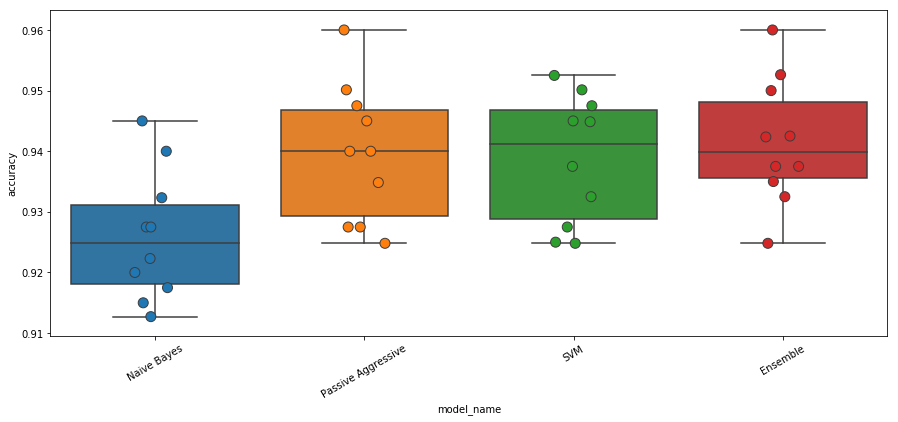

In [114]:
tfidf_full_data = tfidf.fit_transform(train['text'])

VC_Classifier_Plot(tfidf_full_data, target)

In [115]:
def news_classifier_pipeline(data):
    '''function to create a pipeline to clean the data'''

    # lowercase
    data['text'] = data['text'].apply(lower_case)
    
    # clean up urls
    data['text'] = data['text'].apply(lower_case)
    
    # decontract
    data['text'] = data['text'].apply(decontract)
    
    # remove punctuation and lower case
    data['text'] = data['text'].apply(remove_punctuation)
    
    # toeknize and lemmatize
    data['text'] = data['text'].apply(tokenize_text)
    data['text'] = data['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x]))
    
    # vectorize
    tfidf_new_data = tfidf.transform(data['text'])
    
    # predict
    prediction = VC_model.predict(tfidf_new_data)
    
    return prediction